In [7]:
import pandas as pd
import numpy as np
from llama_index.embeddings.ollama import OllamaEmbedding
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

class Toxic_Rail:
    """
    A class to handle training and prediction of toxicity in comments using embeddings and a Random Forest classifier.

    Attributes:
    embed_model (OllamaEmbedding): The embedding model used for generating text embeddings.
    model (RandomForestClassifier): The trained Random Forest model for prediction.
    df_train (DataFrame): The prepared training data.
    """

    def __init__(self, mode, input_path=None):
        """
        Initializes the Toxic_Rail class with either training or prediction mode.

        Args:
        mode (str): The mode of operation, either "train" or "predict".
        input_path (str, optional): The path to the input CSV file for training.
        """
        self.embed_model = OllamaEmbedding(model_name="mxbai-embed-large:latest")
        self.X = pd.DataFrame([])
        if mode == "train":
            self.X, self.model = self.train(input_path, "model/clf.mdl")
        if mode == "predict":
            self.model = pickle.load(open("model/clf.mdl", "rb"))
        if mode == "evaluate":
            self.model = pickle.load(open("model/clf.mdl", "rb"))
            self.evaluate(input_path)

    def evaluate(self, test_path):
        tqdm.pandas()
        df_test = self.prepare_data(test_path)
        embeddings = df_test['comment_text'].progress_apply(self.get_embeddings)
        columns = ["embed_" + str(i) for i in range(len(embeddings[0]))]
        X_test = pd.DataFrame(embeddings.tolist(), columns=columns)
        y_test = df_test['label']
        score = self.model.score(X_test, y_test)
        auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
        return score, auc_val
        

    def train(self, input_path, model_persist_path):
        """
        Trains the Random Forest model on the provided dataset and saves the model.

        Args:
        input_path (str): The path to the input CSV file for training.
        model_persist_path (str): The path where the trained model will be saved.
        """
        tqdm.pandas()
        self.df_train = self.prepare_data(input_path)
        embeddings = self.df_train['comment_text'].progress_apply(self.get_embeddings)
        columns = ["embed_" + str(i) for i in range(len(embeddings[0]))]
        X = pd.DataFrame(embeddings.tolist(), columns=columns)
        y = self.df_train['label']
        clf = RandomForestClassifier(max_depth=16, random_state=0).fit(X, y)
        print(clf.score(X, y))
        pickle.dump(clf, open(model_persist_path, "wb"))
        return X, clf

    def predict(self, text):
        """
        Predicts the toxicity label for a given text using the trained model.

        Args:
        text (str): The text to be classified.

        Returns:
        array: The predicted label for the input text.
        """
        test_embed = self.embed_model.get_text_embedding(text)
        column_names = ["embed_" + str(i) for i in range(len(test_embed))]
        X_test = pd.DataFrame([test_embed], columns=column_names)
        return self.model.predict(X_test)

    def create_label(self, row):
        """
        Creates a combined label for a row of the dataset based on individual toxicity indicators.

        Args:
        row (Series): A row from the dataset.

        Returns:
        str: The combined label for the row.
        """
        label = "|"
        if row["toxic"] == 1:
            label += "toxic|"
        if row["severe_toxic"] == 1:
            label += "severe_toxic|"
        if row["obscene"] == 1:
            label += "obscene|"
        if row["threat"] == 1:
            label += "threat|"
        if row["insult"] == 1:
            label += "insult|"
        if row["identity_hate"] == 1:
            label += "identity_hate|"
        if label == "|":
            label = "|non_toxic|"
        return label

    def get_embeddings(self, text):
        """
        Generates embeddings for a given text using the embedding model.

        Args:
        text (str): The text to be embedded.

        Returns:
        list: The embedding of the text.
        """
        return self.embed_model.get_text_embedding(text=text)

    def prepare_data(self, input_path):
        """
        Prepares the training data by reading from a CSV file, creating labels, 
        and balancing the dataset. The original dataset from here - 
        https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

        Args:
        input_path (str): The path to the input CSV file.

        Returns:
        DataFrame: The prepared training data.
        """
        df = pd.read_csv(input_path)
        df["label"] = df.progress_apply(self.create_label, axis=1)
        toxic_df = df.iloc[np.where(df["label"] != "|non_toxic|")]
        non_toxic_df = df.iloc[np.where(df["label"] == "|non_toxic|")].head(10000)
        df = pd.concat([toxic_df, non_toxic_df], ignore_index=True, sort=False)
        return df

In [ ]:
toxic_rail = Toxic_Rail(mode="train", input_path="../data/toxic_train.csv")

In [ ]:
features = pd.Series(toxic_rail.model.feature_importances_, index=toxic_rail.model.feature_names_in_)
sig_features = features.sort_values(ascending=False)
sig_features[:25]

embed_106    0.011757
embed_929    0.009635
embed_595    0.009276
embed_655    0.008977
embed_457    0.008607
embed_819    0.008421
embed_306    0.008229
embed_854    0.007646
embed_790    0.007553
embed_236    0.006494
embed_630    0.006465
embed_261    0.005858
embed_837    0.005789
embed_494    0.005258
embed_330    0.004792
embed_611    0.004733
embed_832    0.004543
embed_770    0.004522
embed_538    0.004425
embed_395    0.004412
embed_347    0.004364
embed_430    0.004275
embed_869    0.004209
embed_17     0.003578
embed_680    0.003564
dtype: float64

In [17]:
toxic_rail.X

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_1014,embed_1015,embed_1016,embed_1017,embed_1018,embed_1019,embed_1020,embed_1021,embed_1022,embed_1023
0,0.141003,-0.515453,0.117342,-0.151029,0.176704,-1.071340,-0.116100,0.067025,0.402112,-0.257644,...,0.807678,-0.286721,-0.674887,-0.424120,0.615931,1.277470,-0.059911,-0.192127,-0.089621,0.254334
1,0.486102,-0.339577,-0.492851,1.383280,0.466505,-0.522365,-0.071882,0.752013,0.167232,0.396679,...,0.123526,-0.319550,0.221024,-1.082147,0.962487,0.626008,-0.053592,0.112897,-0.514728,0.082932
2,-0.419772,-0.108883,0.147845,0.847346,-0.952725,-0.721706,0.496017,0.662555,0.103173,-0.087977,...,-0.006730,-0.474099,-0.259834,0.541007,-0.574912,1.044168,0.150496,-0.526069,0.007920,-0.404412
3,0.384405,-0.556109,-0.448874,0.282773,-0.330971,-0.834489,0.210183,0.558663,-0.459292,0.436052,...,0.901741,-0.226430,-0.371994,-0.021474,0.415404,0.952572,-0.442918,-0.679476,-0.725806,-0.277849
4,0.142132,0.202747,0.307556,0.266274,-0.550268,-0.911743,0.510348,0.199217,0.562032,-0.165540,...,-0.023973,-0.135361,-0.727540,-0.804563,0.418013,0.906514,-0.211707,-0.819588,0.557572,-0.162912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26220,0.693815,-0.591036,-0.249178,0.903433,-0.182100,-0.596748,0.198889,0.436847,-0.400203,0.981873,...,0.462109,-0.350674,0.472688,-0.625908,1.046507,0.559431,-0.339056,-0.738931,-0.280899,0.141591
26221,0.083245,-0.053218,-0.482346,0.296646,0.538907,-0.439882,0.035178,-0.067058,0.568640,0.318116,...,0.684759,-0.204121,-0.053397,-0.177510,0.642937,-0.031539,0.364668,0.472892,-0.739840,-0.379592
26222,0.145235,0.613305,-0.250579,0.313689,-0.428514,-0.555808,-0.164666,-0.138254,-0.026087,0.450211,...,0.658067,-0.389469,-0.599763,0.043732,0.185613,0.692209,0.611745,0.333912,0.459865,0.181334
26223,0.020747,-1.048290,-0.719999,0.072271,-0.667061,-1.046542,0.243985,-0.089006,0.441462,0.223148,...,-0.050121,-0.453998,0.003805,-0.301670,0.329132,-0.017968,-0.189145,-0.065683,0.767873,0.169451


In [18]:
import matplotlib.colors as mcolors
mcolors.CSS4_COLORS

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [19]:
colors = list(mcolors.CSS4_COLORS.values())
y = toxic_rail.df_train['label']
keys = y.unique()
color_map = {k:colors[i] for i,k in enumerate(keys)}
color_map

{'|toxic|severe_toxic|obscene|insult|': '#F0F8FF',
 '|toxic|': '#FAEBD7',
 '|toxic|obscene|insult|identity_hate|': '#00FFFF',
 '|toxic|obscene|insult|': '#7FFFD4',
 '|toxic|obscene|': '#F0FFFF',
 '|toxic|threat|': '#F5F5DC',
 '|toxic|insult|': '#FFE4C4',
 '|toxic|obscene|threat|insult|identity_hate|': '#000000',
 '|insult|': '#FFEBCD',
 '|obscene|': '#0000FF',
 '|toxic|severe_toxic|obscene|': '#8A2BE2',
 '|toxic|obscene|threat|insult|': '#A52A2A',
 '|toxic|severe_toxic|obscene|insult|identity_hate|': '#DEB887',
 '|toxic|severe_toxic|obscene|threat|insult|identity_hate|': '#5F9EA0',
 '|toxic|insult|identity_hate|': '#7FFF00',
 '|toxic|identity_hate|': '#D2691E',
 '|obscene|insult|': '#FF7F50',
 '|toxic|severe_toxic|obscene|identity_hate|': '#6495ED',
 '|toxic|severe_toxic|obscene|threat|insult|': '#FFF8DC',
 '|identity_hate|': '#DC143C',
 '|toxic|obscene|identity_hate|': '#00FFFF',
 '|threat|': '#00008B',
 '|obscene|insult|identity_hate|': '#008B8B',
 '|toxic|severe_toxic|': '#B8860B',


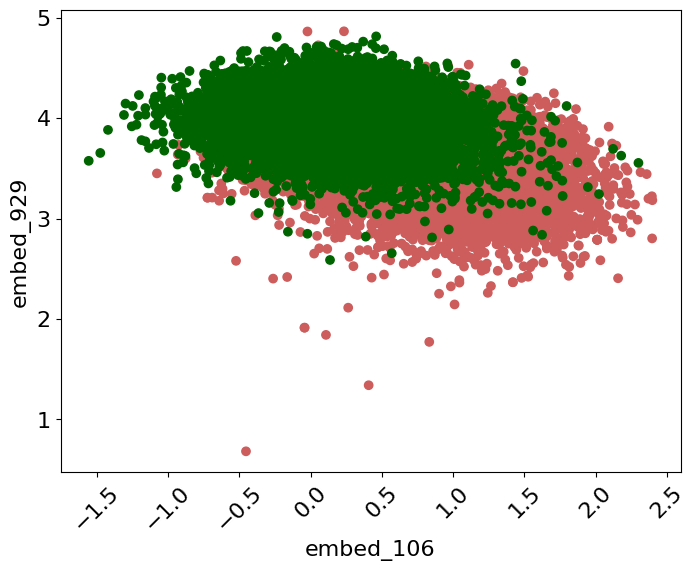

In [20]:
# plot data along top 2 most important features
import matplotlib.pyplot as plt

c_arr = np.array(["k"] * len(y))
#c_arr = [color_map[l] for l in y] 
c_arr = ["#006400" if(l == "|non_toxic|") else "#CD5C5C" for l in y]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(toxic_rail.X[sig_features.index[0]], toxic_rail.X[sig_features.index[1]], c=c_arr)
plt.xticks(rotation = 45)
plt.xlabel(sig_features.index[0])
plt.ylabel(sig_features.index[1])
plt.show()

In [21]:
toxic_rail_pred = Toxic_Rail(mode="predict")

In [22]:
text = "He is obviously a fistfuckee. He loves an arm up his ass"
toxic_rail_pred.predict(text)

array(['|toxic|obscene|insult|'], dtype=object)

In [23]:
text = "You should be kicked out, you're a moronic wimp who is too lazy to do any work. It makes me sick that people like you exist in this world."
toxic_rail_pred.predict(text)

array(['|toxic|obscene|insult|'], dtype=object)

In [24]:
text = "I want to understand how to use the classification models with embeddings to filter out toxic text"
toxic_rail_pred.predict(text)

array(['|non_toxic|'], dtype=object)